In [1]:
import keras
import keras.backend as K

Using TensorFlow backend.


In [2]:
import os

In [3]:
os.listdir('data')

['spec', 'super-raw', 'raw']

In [4]:
import numpy as np

In [5]:
x = np.load('data/spec/The Airborne Toxic Event-The Airborne Toxic Event Deluxe Edition-Happiness Is Overrated.mp3 - 107 sec.npy')

In [6]:
x

array([[  5.10694777e-07,   1.10282666e-06,   8.77621656e-07, ...,
          1.83597571e-07,   1.76248167e-05,   4.24043893e-06],
       [  9.08853106e-07,   2.40361369e-06,   1.43610808e-06, ...,
          1.34090250e-07,   3.23502642e-05,   6.28688850e-06],
       [  1.45927754e-06,   4.09228860e-06,   2.21396286e-06, ...,
          9.36392313e-08,   5.24146331e-05,   9.10984876e-06],
       ..., 
       [  6.94744062e-06,   1.33959007e-06,   1.39344060e-06, ...,
          1.05777076e-05,   6.23164437e-06,   4.16239555e-06],
       [  6.14303373e-06,   1.69865827e-06,   1.73036971e-06, ...,
          1.27627823e-05,   4.32768057e-06,   4.48100764e-06],
       [  5.30756535e-06,   2.09302689e-06,   1.99053286e-06, ...,
          1.48864400e-05,   2.88151596e-06,   4.90735290e-06]])

In [7]:
x.shape

(184, 1574)

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
spec_dir = 'data/spec'
spectrograms = [os.path.join(spec_dir, f) for f in os.listdir(spec_dir)]

In [10]:
import random

In [11]:
from sklearn.preprocessing import maxabs_scale 

In [12]:
def load(f):
    return maxabs_scale(np.load(f)).transpose()[:256,:]

data/spec/Beck-Odelay-Novacane.mp3 - 145 sec.npy


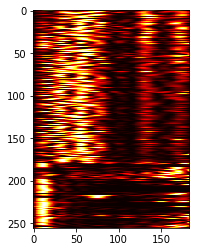

In [13]:
f = random.choice(spectrograms)
print(f)
x = load(f)
plt.imshow(x,  cmap='hot', interpolation='nearest')

In [46]:
from keras.models import Sequential
from keras.layers import Conv1D, Dense, MaxPool1D, UpSampling1D
model = Sequential([
    Conv1D(300, 64, padding='same', activation='relu', input_shape=(256, 184)),
    MaxPool1D(2, padding='same'),
    Conv1D(200, 64, padding='same', activation='relu'),
    MaxPool1D(2, padding='same'),
    Conv1D(128, 32, padding='same', activation='relu'),
    MaxPool1D(2, padding='same'),
    Conv1D(128, 32, padding='same', activation='relu'),
    UpSampling1D(2),
    Conv1D(200, 64, padding='same', activation='relu'),
    UpSampling1D(2),
    Conv1D(300, 64, padding='same', activation='relu', input_shape=(256, 184)),
    UpSampling1D(2),
    Conv1D(184, 1, activation='sigmoid')
])

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 256, 300)          3533100   
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 128, 300)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 128, 200)          3840200   
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 64, 200)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 64, 128)           819328    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 32, 128)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 32, 128)           524416    
__________

In [ ]:
# 1,032,990,720

In [49]:
model.compile(optimizer='adadelta', loss='mean_squared_error')

In [50]:
def data_gen(files, batch_size):
    while True:
        random.shuffle(files)
        X = np.zeros((batch_size, 256, 184))
        for i, f in enumerate(files):
            i = i % batch_size
            X[i,:] = load(f)
            if i == batch_size - 1:
                yield X, X
                X = np.zeros((batch_size, 256, 184))

In [91]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', patience=2, verbose=1)

In [120]:
epochs = 30
batch_size = 30
steps = len(spectrograms) // batch_size
gen = data_gen(spectrograms, batch_size)
model.fit_generator(gen, steps_per_epoch=steps, epochs=epochs, callbacks=[reduce_lr])

Epoch 1/30
304/731 [===========>..................] - ETA: 2:08 - loss: 0.0224

KeyboardInterrupt: 

In [119]:
K.set_value(model.optimizer.lr, .7)

data/spec/White Rabbits-Its Frightening-Midnight And I.mp3 - 177 sec.npy


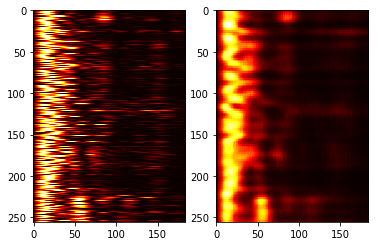

In [129]:
file = random.choice(spectrograms)
print(file)
x = load(file)
x_test = x.reshape(1, 256, 184)
pred = model.predict(x_test)
f, ax = plt.subplots(1, 2)
ax[0].imshow(x,  cmap='hot', interpolation='nearest')
ax[1].imshow(pred[0],  cmap='hot', interpolation='nearest')

In [133]:
from keras.models import Model
encoder = Model(input=model.layers[0].input, output=model.layers[5].output)

/home/dante/venvs/default/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ma..., inputs=Tensor("co...)`
  


In [142]:
def encode(X):
    p = encoder.predict(X)
    return p[0].mean(axis=0)